In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import scanpy.external as scex
import sklearn.metrics
import seaborn as sns
from matplotlib import pyplot as plt
import scanpyHelpers as scH

In [2]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

In [3]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 python-igraph==0.10.4 pynndescent==0.5.12


In [4]:
%matplotlib inline

In [5]:
writeDir = "write/"

fileName = "luadBischoff"

resultsFile = writeDir + fileName + '.h5ad'       # final output
resultsFileQC = writeDir + fileName + '_QC.h5ad'  # post QC (pre-analysis) 

In [6]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

In [14]:
adata = sc.read_h5ad(resultsFileQC)
adata

AnnData object with n_obs × n_vars = 103696 × 24344
    obs: 'sample', 'patient', 'cell_type', 'cell_subtype', 'source', 'complexity', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'source_colors'

In [15]:
adata = adata[adata.obs.source=="Tumor"]
adata = adata[adata.obs.cell_type=="Malignant"]
adata

View of AnnData object with n_obs × n_vars = 9565 × 24344
    obs: 'sample', 'patient', 'cell_type', 'cell_subtype', 'source', 'complexity', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'source_colors'

In [16]:
from collections import Counter
Counter(adata.obs.patient)

Counter({'p032': 3170,
         'p018': 3059,
         'p024': 1309,
         'p031': 893,
         'p023': 374,
         'p033': 292,
         'p019': 169,
         'p030': 161,
         'p027': 131,
         'p034': 7})

In [17]:
patient = ['p024','p018','p032']
#adata = adata[adata.obs.patient== patient]
adata = adata[[p in patient for p in adata.obs["patient"]],]

#resultsFile = writeDir + fileName + patient+ '.h5ad'  
#adata.layers["counts"] = adata.X.copy()
adata

View of AnnData object with n_obs × n_vars = 7538 × 24344
    obs: 'sample', 'patient', 'cell_type', 'cell_subtype', 'source', 'complexity', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'source_colors'

In [18]:
sc.pp.normalize_total(adata,target_sum=1e4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
sc.pp.log1p(adata)

In [21]:
sc.pp.highly_variable_genes(adata)#, flavor = "seurat", n_top_genes=2000)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


2275


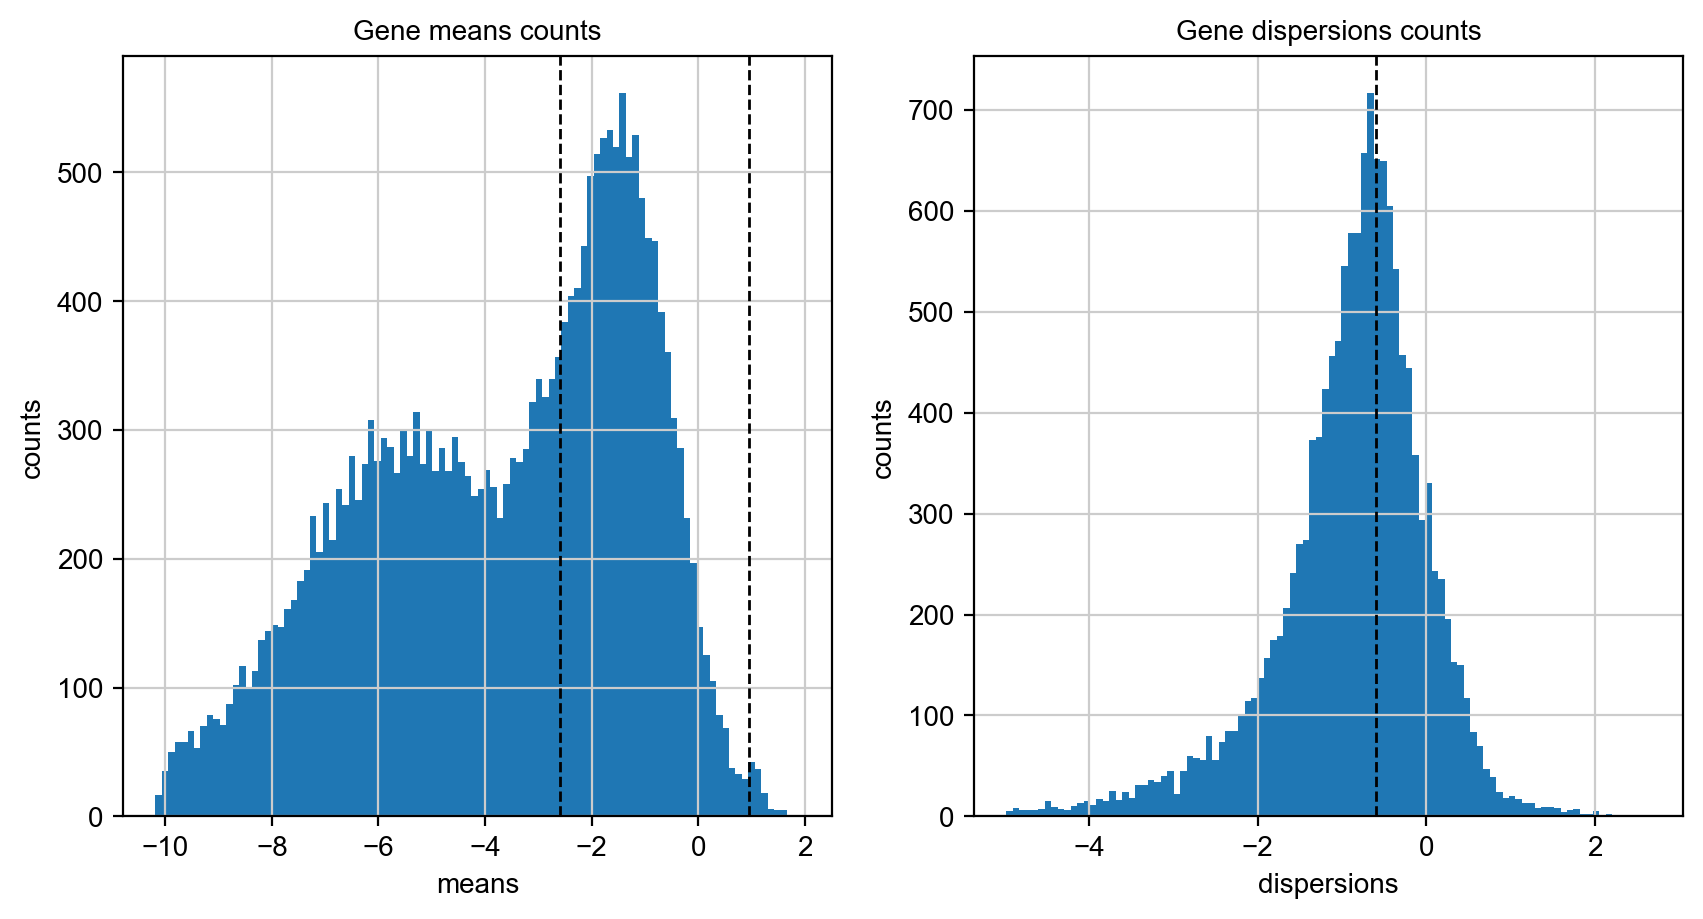

In [25]:
minMean = 0.075
maxMean = 2.6
minDisp = 0.55

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-5)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean)
print(sum(adata.var.highly_variable))

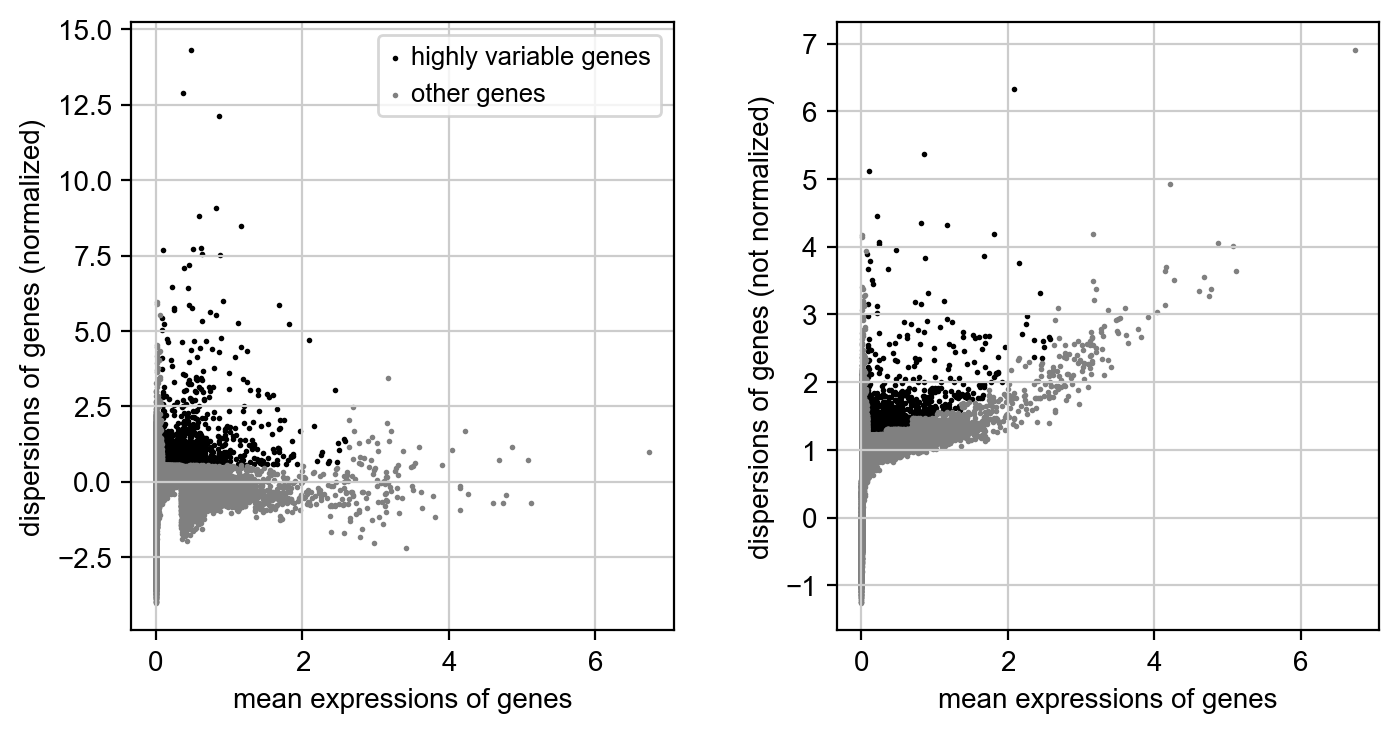

In [26]:
sc.pl.highly_variable_genes(adata)

In [27]:
#for inGene in adata.var[-8:].index.tolist():
#    adata.var.loc[inGene,"highly_variable"] = False

In [28]:
adata.raw = adata

In [29]:
#adata = adata[:, adata.var.highly_variable]
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [30]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [31]:
#sc.pp.scale(adata, max_value=10)

In [32]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


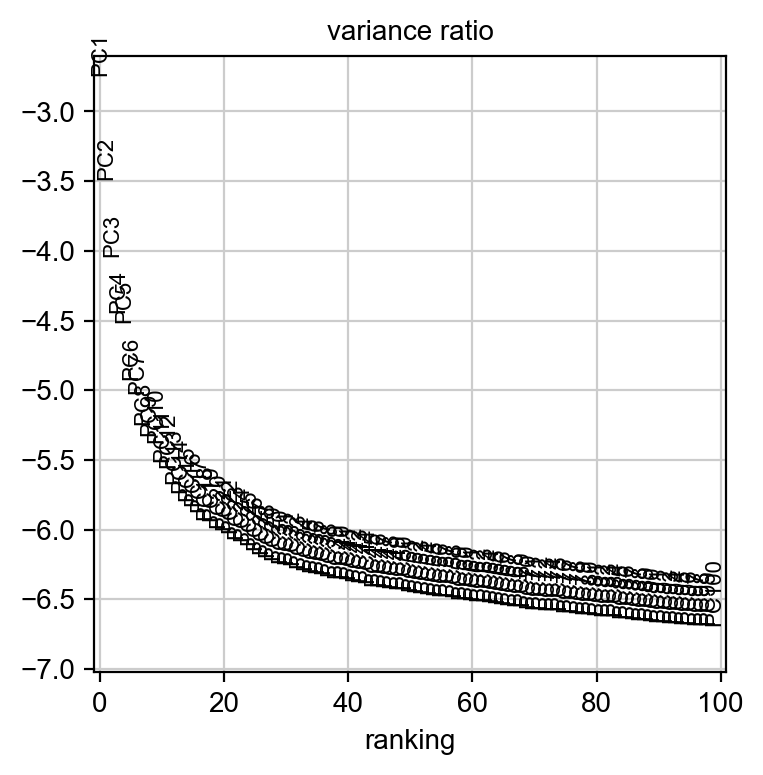

In [33]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100, log=True)

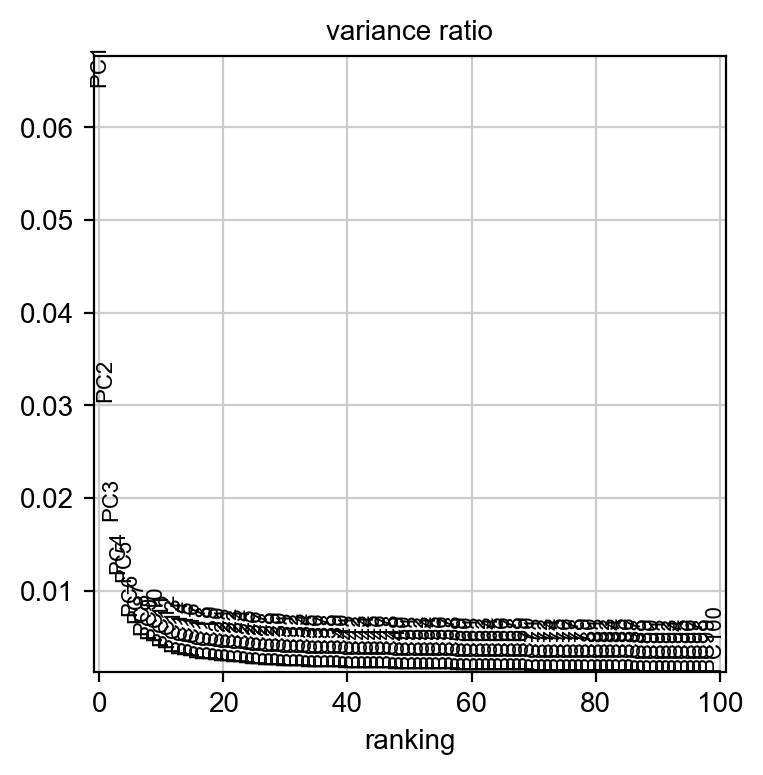

In [34]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100)

In [35]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=60)

In [36]:
sc.tl.umap(adata)

In [39]:
sc.tl.leiden(adata, resolution=0.7)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

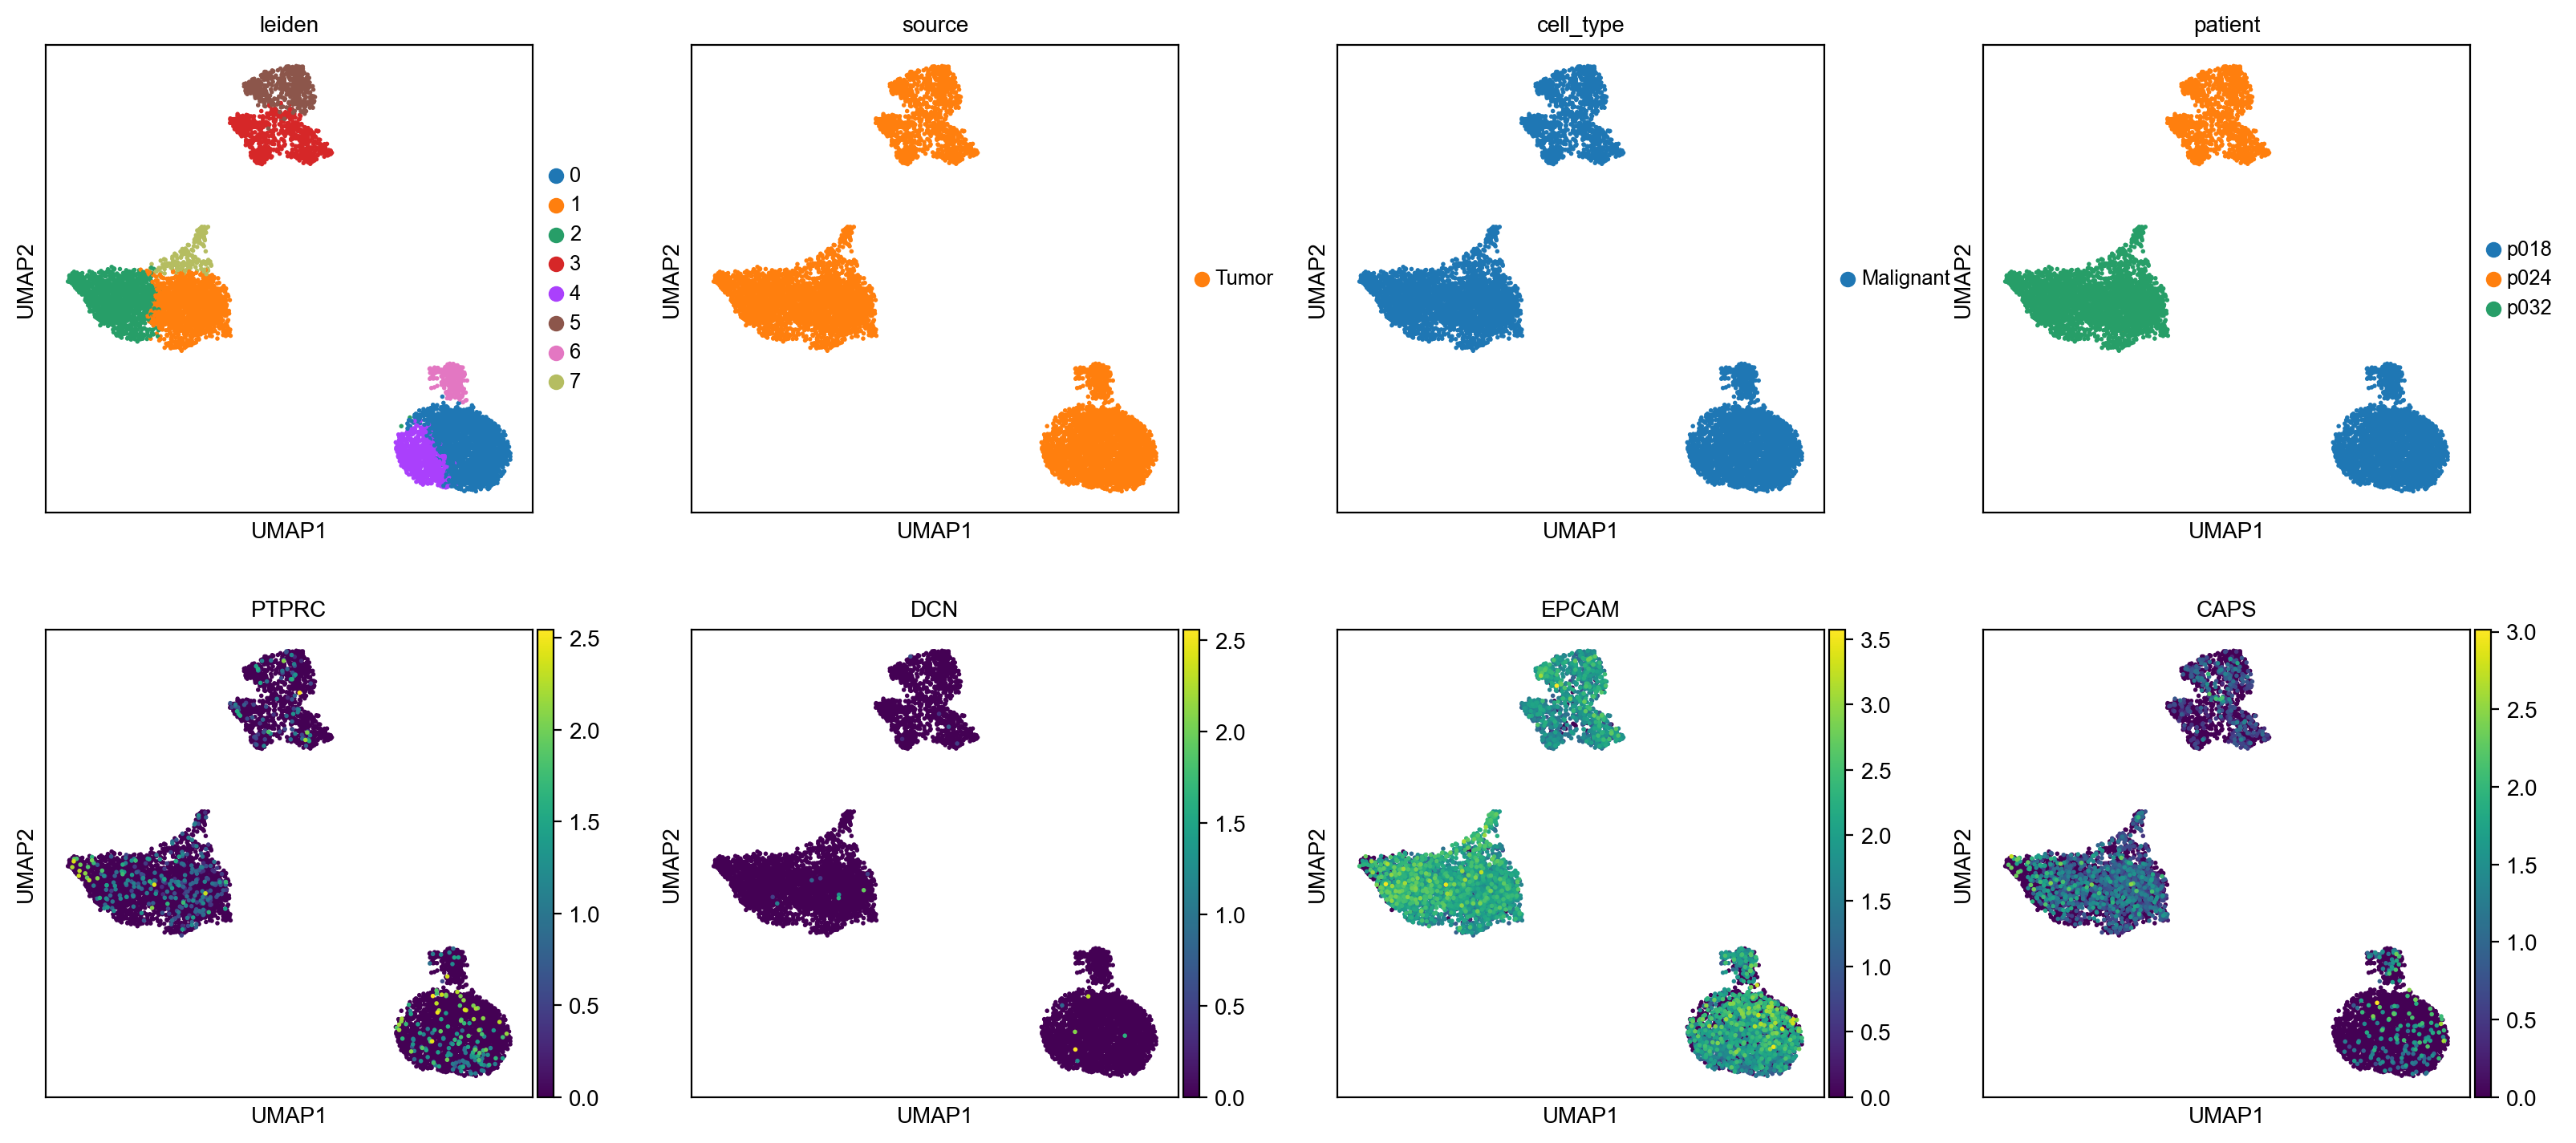

In [40]:
sc.pl.umap(adata, color=["leiden","source","cell_type","patient","PTPRC","DCN","EPCAM","CAPS"],ncols=4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

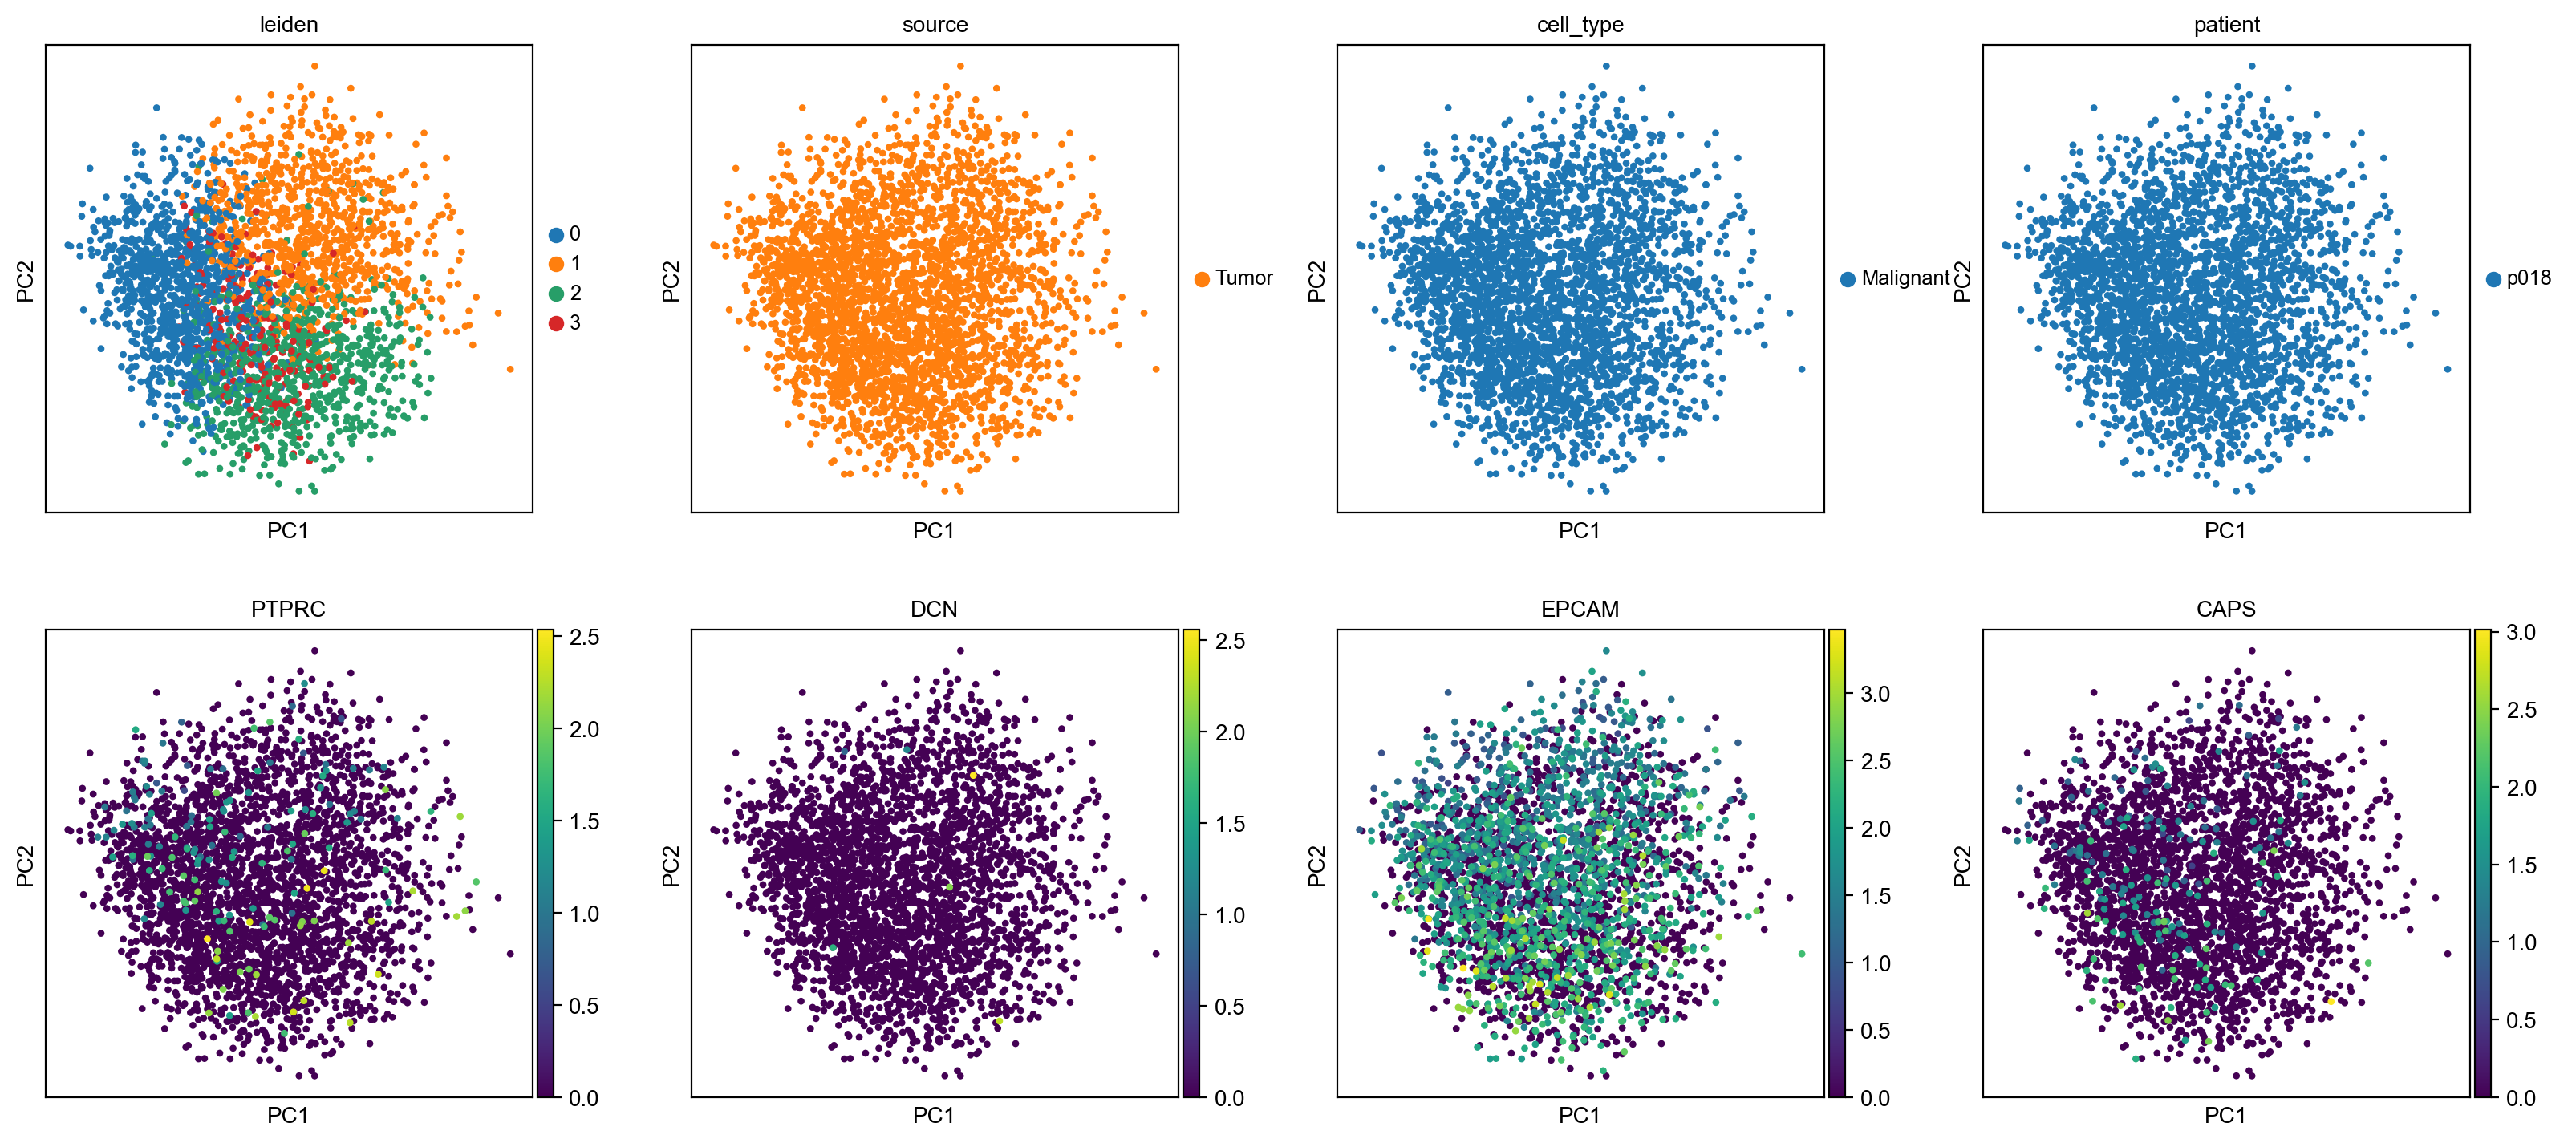

In [289]:
sc.pl.pca(adata, color=["leiden","source","cell_type","patient","PTPRC","DCN","EPCAM","CAPS"],ncols=4)

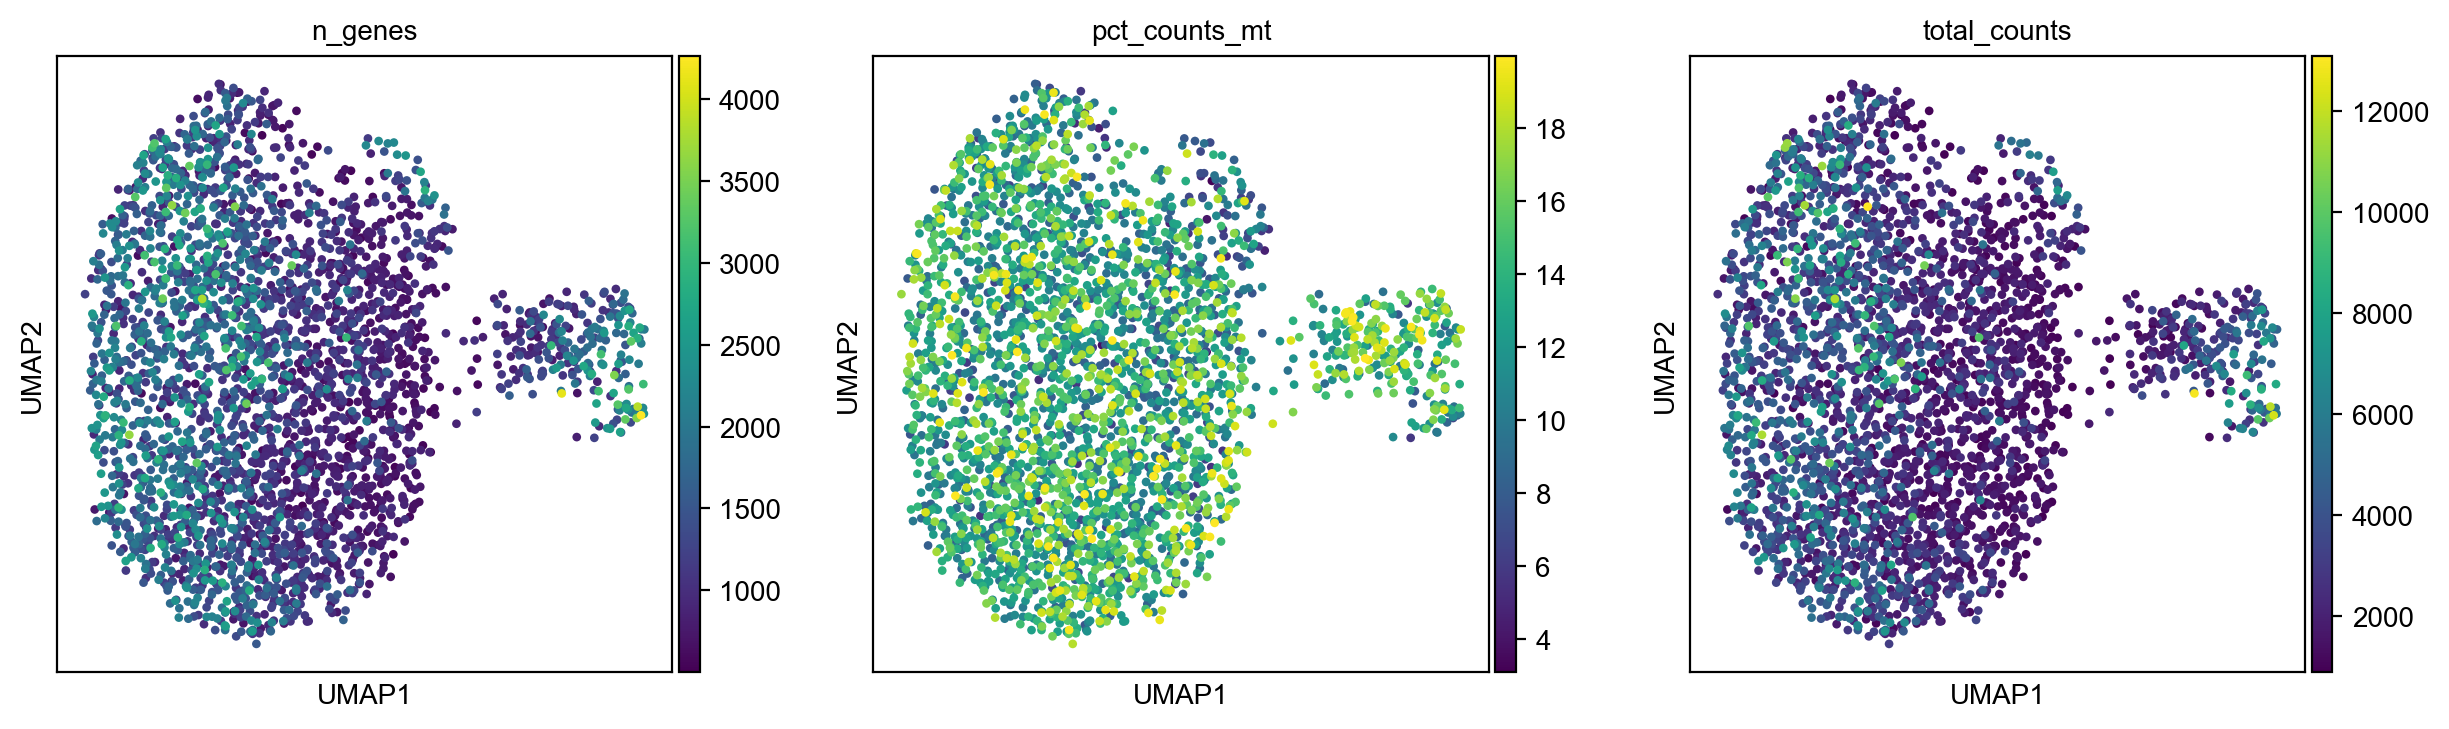

In [290]:
sc.pl.umap(adata, color=["n_genes","pct_counts_mt","total_counts"])

In [291]:
adata.uns['log1p']['base']=None

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


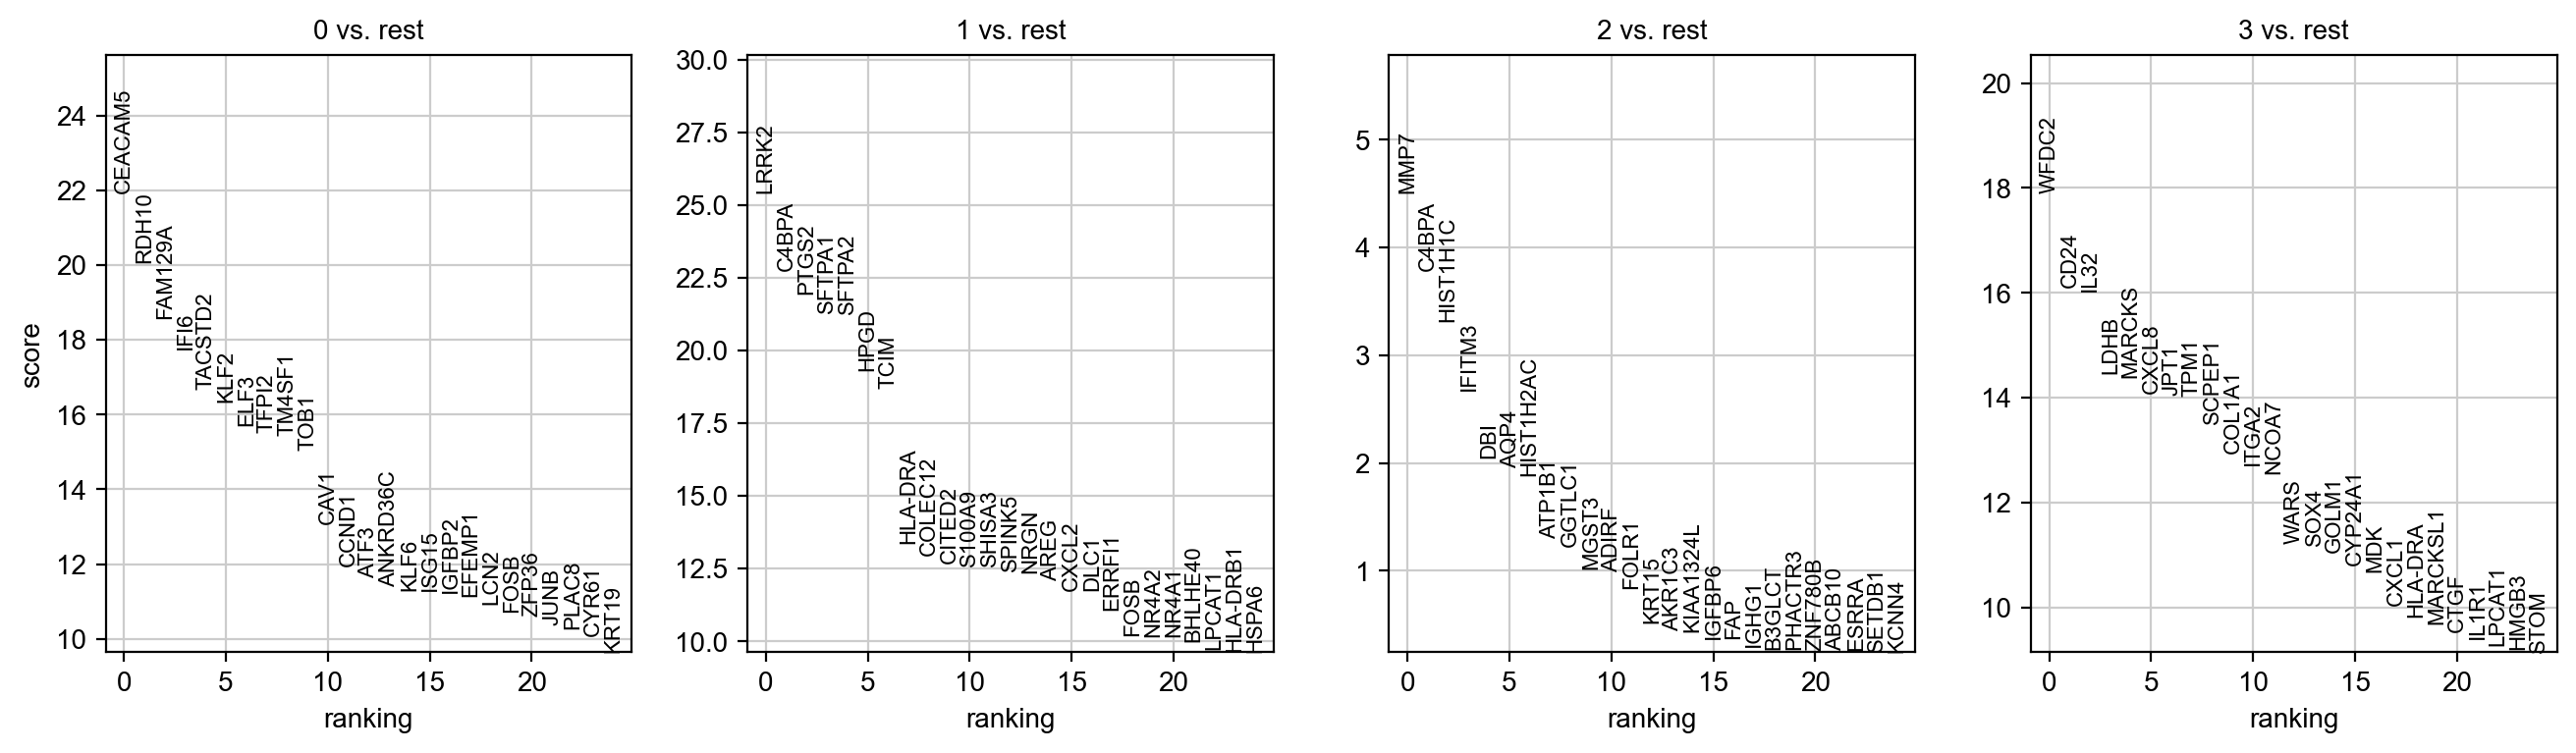

In [292]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=False)
#sc.tl.filter_rank_genes_groups(adata, groupby="leiden", use_raw=False,
#                                   key_added='rank_genes_groups_filtered', 
#                                   min_in_group_fraction=0.5, min_fold_change=1, max_out_group_fraction=0.5, compare_abs=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [293]:
#pd.DataFrame(adata.uns['rank_genes_groups_filtered']['names']).head(15)

In [41]:
resultsFile

'write/luadBischoff.h5ad'

In [42]:
adata

AnnData object with n_obs × n_vars = 7538 × 2274
    obs: 'sample', 'patient', 'cell_type', 'cell_subtype', 'source', 'complexity', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'source_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_type_colors', 'patient_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [43]:
adata.write(resultsFile)
adata

AnnData object with n_obs × n_vars = 7538 × 2274
    obs: 'sample', 'patient', 'cell_type', 'cell_subtype', 'source', 'complexity', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'source_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_type_colors', 'patient_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'